In [ ]:
%matplotlib inline
#pytorch packages
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#To download the dataset for torchvision
import torchvision
from torchvision import datasets, transforms
#For plots
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
PATH = '.'

In [ ]:
trn_set = datasets.MNIST(PATH, train=True, download=True)
tst_set = datasets.MNIST(PATH, train=False, download=True)

In [ ]:
len(trn_set.train_data), len(tst_set.test_data)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


(60000, 10000)

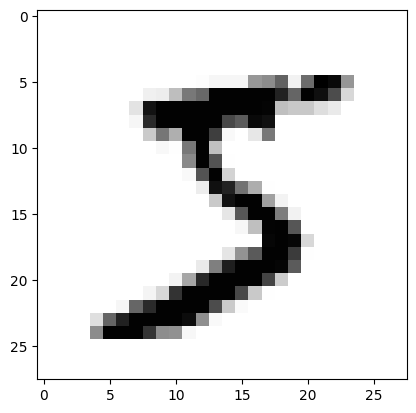

In [ ]:
plt.imshow(trn_set.train_data[0].numpy(), cmap="Greys")

In [ ]:
tsfms = transforms.ToTensor()
trn_set = datasets.MNIST(PATH, train=True, download=True, transform=tsfms)
tst_set = datasets.MNIST(PATH, train=False, download=True, transform=tsfms)
trn_loader = torch.utils.data.DataLoader(trn_set, batch_size=64, shuffle=True, num_workers=0)
tst_loader = torch.utils.data.DataLoader(tst_set, batch_size=64, shuffle=False, num_workers=0)

In [ ]:
mb_example = next(iter(trn_loader))

In [ ]:
mb_example[0].size(), mb_example[1].size()

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [ ]:
mb_example[0][0, 0]

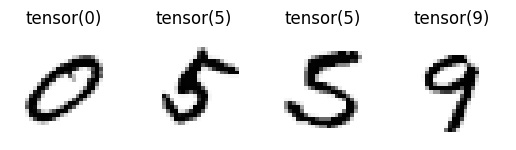

In [ ]:
fig = plt.figure()
for i in range(4):
    sub_plot = fig.add_subplot(1, 4, i+1)
    sub_plot.axis("Off")
    plt.imshow(mb_example[0][i, 0].numpy(), cmap="Greys")
    sub_plot.set_title(mb_example[1][i])

In [ ]:
mean = torch.mean(trn_set.train_data.type(torch.FloatTensor))/255.
std = torch.std(trn_set.train_data.type(torch.FloatTensor))/255.
mean, std

(tensor(0.1307), tensor(0.3081))

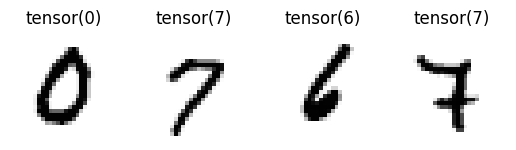

In [ ]:
tsfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])
trn_set = datasets.MNIST(PATH, train=True, download=True, transform=tsfms)
tst_set = datasets.MNIST(PATH, train=False, download=True, transform=tsfms)

trn_loader = torch.utils.data.DataLoader(trn_set, batch_size=64, shuffle=True, num_workers=0)
tst_loader = torch.utils.data.DataLoader(tst_set, batch_size=64, shuffle=False, num_workers=0)
mb_example = next(iter(trn_loader))
fig = plt.figure()
for i in range(0,4):
    sub_plot = fig.add_subplot(1,4,i+1)
    sub_plot.axis('Off')
    plt.imshow(mb_example[0][i,0].numpy() * std.numpy() + mean.numpy(), cmap='Greys', interpolation=None)
    sub_plot.set_title(mb_example[1][i])


In [ ]:
class SimpleNeuralNet(nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.linear1 = nn.Linear(n_in, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_out)

    def forward(self,x):
        x = x.view(x.size(0),-1)
        x = F.relu(self.linear1(x))
        return F.log_softmax(self.linear2(x), dim=-1)

In [ ]:
net = SimpleNeuralNet(28*28,100,10)
optimizer = optim.SGD(net.parameters(),lr=1e-2)

In [ ]:
def train(nb_epoch):
    for epoch in range(nb_epoch):
        running_loss = 0.
        corrects = 0
        print(f'Epoch {epoch+1}:')
        for data in trn_loader:
            #separate the inputs from the labels
            inputs,labels = data
            #wrap those into variables to keep track of how they are created and be able to compute their gradient.
            #Put the gradients back to zero
            optimizer.zero_grad()
            #Compute the outputs given by our model at this stage.
            outputs = net(inputs)
            _,preds = torch.max(outputs.data,1)
            #Compute the loss
            loss = F.nll_loss(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            corrects += torch.sum(labels.data == preds)
            #Backpropagate the computation of the gradients
            loss.backward()
            #Do the step of the SGD
            optimizer.step()
        print(f'Loss: {running_loss/len(trn_set)}  Accuracy: {100.*corrects/len(trn_set)}')

In [ ]:
train(10)

Epoch 1:
Loss: 0.5846278077443441  Accuracy: 85.23666381835938
Epoch 2:
Loss: 0.30402929018735886  Accuracy: 91.32833099365234
Epoch 3:
Loss: 0.25784419357776645  Accuracy: 92.6050033569336
Epoch 4:
Loss: 0.22666496206124623  Accuracy: 93.5250015258789
Epoch 5:
Loss: 0.20227225366830826  Accuracy: 94.23833465576172
Epoch 6:
Loss: 0.18257906008958816  Accuracy: 94.7699966430664
Epoch 7:
Loss: 0.16668724185029665  Accuracy: 95.26667022705078
Epoch 8:
Loss: 0.1528758931696415  Accuracy: 95.69000244140625
Epoch 9:
Loss: 0.14134145741661389  Accuracy: 96.00333404541016
Epoch 10:
Loss: 0.13114392293890317  Accuracy: 96.30999755859375


In [ ]:
def validate():
    running_loss = 0.
    corrects = 0
    for data in tst_loader:
        #separate the inputs from the labels
        inputs,labels = data
        #wrap those into variables to keep track of how they are created and be able to compute their gradient.
        #Even if we don't require the gradient here, a nn.Module expects a variable.
        #Compute the outputs given by our model at this stage.
        outputs = net(inputs)
        _,preds = torch.max(outputs.data,1)
        #Compute the loss
        loss = F.nll_loss(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        corrects += torch.sum(labels.data == preds)
    print(f'Loss: {running_loss/len(tst_set)}  Accuracy: {100.*corrects/len(tst_set)}')

In [ ]:
validate()

Loss: 0.13463953781425952  Accuracy: 96.12000274658203


In [ ]:
def my_find_lr(init_value = 1e-8, final_value=10, beta = 0.98):
  num = len(trn_loader) - 1
  mult = (final_value/init_value)**(1/num)
  curr_lr = init_value
  curr_loss = 0.
  lr_logs = []
  loss_logs = []
  for ith, (data, targets) in enumerate(trn_loader):
    optimizer.param_groups[0]["lr"] = curr_lr
    logits = net(data)
    loss = nn.NLLLoss()(logits, targets)
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()
    curr_loss = (beta*curr_loss + (1-beta)*loss.item())
    smoothed_loss = curr_loss/(1 - beta**(ith+1))
    loss_logs.append(smoothed_loss)
    lr_logs.append(math.log10(curr_lr))

    curr_lr *= mult
  return lr_logs, loss_logs

In [ ]:
net = SimpleNeuralNet(28*28,100,10)
optimizer = optim.Adam(net.parameters(),lr=1e-1)
lr_logs, loss_logs = my_find_lr()

In [ ]:
len(lr_logs)

938

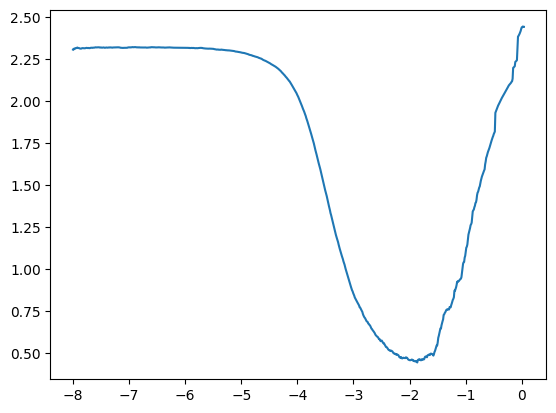

In [ ]:
plt.plot(lr_logs[:-100], loss_logs[:-100])

In [ ]:
loss_logs[-1]

3.641611452722915e+24

In [ ]:
net = SimpleNeuralNet(28*28,100,10)
optimizer = optim.Adam(net.parameters(),lr=1e-3)
train(10)

Epoch 1:
Loss: 0.2762827971378962  Accuracy: 91.91166687011719
Epoch 2:
Loss: 0.12301396138469378  Accuracy: 96.336669921875
Epoch 3:
Loss: 0.08500602347950141  Accuracy: 97.4000015258789
Epoch 4:
Loss: 0.06643336378286283  Accuracy: 97.9800033569336
Epoch 5:
Loss: 0.05379368597057958  Accuracy: 98.28666687011719
Epoch 6:
Loss: 0.04429757197375099  Accuracy: 98.58499908447266
Epoch 7:
Loss: 0.03524560263734311  Accuracy: 98.84833526611328
Epoch 8:
Loss: 0.03108557256919642  Accuracy: 98.95500183105469
Epoch 9:
Loss: 0.02810656616035849  Accuracy: 99.06999969482422
Epoch 10:
Loss: 0.023348790275879824  Accuracy: 99.24666595458984
